# Tutorial 9: Dealing with missing data

Synthcity does not handle missing data on it's own. It assumes that you have imputed any missing values yourself first. So, in this tutorial, we will learn how to do this with another of the van der Schaar Lab's modules, `HyperImpute`. We will then show that we can happily generate a synthetic data afterwards.

### Imports

In [1]:
import sys
import warnings

import numpy as np
import pandas as pd

from sklearn.datasets import load_diabetes

from hyperimpute.plugins.utils.simulate import simulate_nan

from IPython.display import display

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from synthcity.plugins.core.dataloader import GenericDataLoader

### Load the data

We will use the diabetes dataset from SKLearn, but we need to introduce some NaN values in order to simulate the missingness that we will then fix with HyperImpute.

In [2]:

# Load baseline dataset
X, y = load_diabetes(as_frame=True, return_X_y=True)
df_ = pd.concat([X, y], axis=1)

# Simulate missing data
percentage_missing = 0.2
mechanism = "MCAR"
x_miss = simulate_nan(np.asarray(df_), percentage_missing, mechanism)["X_incomp"]


df = pd.DataFrame(x_miss, columns = df_.columns)
print("The diabetes dataset with 20% missing values.\n")
print(df.head())


The diabetes dataset with 20% missing values.

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696       NaN       NaN -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451       NaN -0.045599       NaN -0.032356   
3       NaN -0.044642       NaN -0.036656  0.012191       NaN -0.036038   
4  0.005383       NaN -0.036385  0.021872       NaN       NaN  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646     NaN  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4       NaN -0.031988       NaN     NaN  


### Try to Generate synthetic data

In [3]:
loader = GenericDataLoader(
    df,
    target_column="target",
    sensitive_columns=["sex"],
)

In [4]:
# synthcity absolute
from synthcity.plugins import Plugins

syn_model = Plugins().get("ctgan")

syn_model.fit(loader)

2023-06-01 17:21:10,321 - Created a temporary directory at /tmp/tmp0xnhplub
2023-06-01 17:21:10,322 - Writing /tmp/tmp0xnhplub/_remote_module_non_scriptable.py


ValueError: Input X contains NaN.
BayesianGaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Whoops! Here we see that Synthcity cannot handle NaN values. Proof that we need to impute first!

### Lets Impute
First we can view the different possible Imputation plugins

In [5]:
from hyperimpute.plugins.imputers import Imputers, ImputerPlugin

imputers = Imputers()
imputers.list()

['miwae',
 'sklearn_missforest',
 'miracle',
 'most_frequent',
 'hyperimpute',
 'EM',
 'gain',
 'median',
 'sklearn_ice',
 'mice',
 'mean',
 'ice',
 'missforest',
 'nop',
 'sinkhorn',
 'softimpute']

### Load an imputer
Imputers are loaded with `Imputers().get(method_name)`. Below we explain all the parameters we are using as well.

In [6]:
imputer = Imputers().get(
    "hyperimpute",  # the name of the imputation method.
    # The rest of the kwargs are specific to the method
    # optimizer: str. The optimizer to use: simple, hyperband, bayesian
    optimizer="hyperband",
    # classifier_seed: list. Model search pool for categorical columns.
    classifier_seed=["logistic_regression", "catboost", "xgboost", "random_forest"],
    # regression_seed: list. Model search pool for continuous columns.
    regression_seed=[
        "linear_regression",
        "catboost_regressor",
        "xgboost_regressor",
        "random_forest_regressor",
    ],
    # class_threshold: int. how many max unique items must be in the column to be is associated with categorical
    class_threshold=5,
    # imputation_order: int. 0 - ascending, 1 - descending, 2 - random
    imputation_order=2,
    # n_inner_iter: int. number of imputation iterations
    n_inner_iter=10,
    # select_model_by_column: bool. If true, select a different model for each column. Else, it reuses the model chosen for the first column.
    select_model_by_column=True,
    # select_model_by_iteration: bool. If true, selects new models for each iteration. Else, it reuses the models chosen in the first iteration.
    select_model_by_iteration=True,
    # select_lazy: bool. If false, starts the optimizer on every column unless other restrictions apply. Else, if for the current iteration there is a trend(at least to columns of the same type got the same model from the optimizer), it reuses the same model class for all the columns without starting the optimizer.
    select_lazy=True,
    # select_patience: int. How many iterations without objective function improvement to wait.
    select_patience=5,
)


### Impute the missing values
We impute the missing values with `imputer.fit_transform()`, which is a style you may be familiar with from library `sklearn`.

In [18]:
x_imputed = imputer.fit_transform(df.copy())
display(x_imputed)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.036598,-0.028982,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,235.281221
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.000000
2,0.085299,0.050680,0.044451,0.008739,-0.045599,-0.043475,-0.032356,-0.002592,0.002861,-0.025930,141.000000
3,-0.014735,-0.044642,0.019753,-0.036656,0.012191,0.017234,-0.036038,0.034309,0.022688,-0.009362,206.000000
4,0.005383,-0.044642,-0.036385,0.021872,-0.022235,-0.023615,0.008142,-0.034137,-0.031988,-0.003815,95.123352
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,0.020585,0.031193,0.007207,178.000000
438,-0.005515,0.050680,-0.015906,-0.006105,0.071843,0.079165,-0.028674,0.034309,-0.018114,0.044485,123.368382
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.024482,0.019257,-0.011080,-0.046883,0.015491,132.000000
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.030381,0.024658,0.044529,-0.025930,220.000000


In [8]:
loader = GenericDataLoader(
    x_imputed,
    target_column="target",
    sensitive_columns=["sex"],
)

In [9]:
# synthcity absolute
from synthcity.plugins import Plugins

syn_model = Plugins().get("ctgan")

syn_model.fit(loader)

 50%|████▉     | 999/2000 [00:26<00:26, 37.12it/s]


In [17]:
X_syn = syn_model.generate(count=df_.shape[0]).dataframe()
display(X_syn.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.041995,0.050680,-0.064871,0.003832,-0.063335,-0.021692,0.049292,-0.011233,-0.061892,-0.005036,178.708153
1,-0.010442,-0.044642,-0.053701,-0.045700,-0.035140,-0.046954,-0.003534,-0.045670,-0.028287,-0.059116,158.288506
2,-0.012305,0.050680,0.014011,0.053512,-0.016200,-0.031202,-0.047944,0.026379,0.035810,0.016790,274.051639
3,-0.107226,-0.044642,-0.047236,-0.070500,-0.019622,-0.032736,0.020071,-0.041136,-0.019809,-0.027935,179.073245
4,0.012606,0.050680,-0.000232,0.034475,0.021446,0.040235,-0.023840,-0.006283,0.010178,0.102730,309.017383


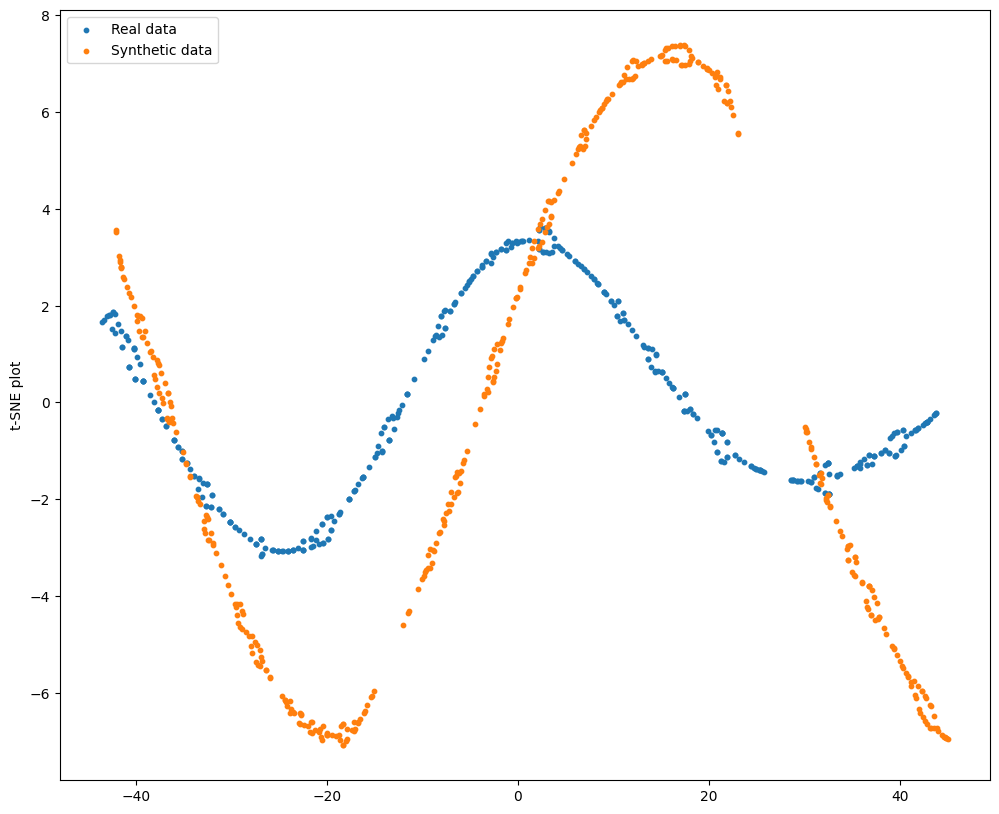

In [15]:
# third party
import matplotlib.pyplot as plt

syn_model.plot(plt, loader, plots=["tsne"])

plt.show()

### Done!
We have now generated synthetic data with synthcity starting from a dataset with missing values thanks to [HyperImpute](https://github.com/vanderschaarlab/hyperimpute). Visit the (HyperImpute tutorials)[https://github.com/vanderschaarlab/hyperimpute/tree/main/tutorials] for more details on how to impute data using the various different methods.

## Congratulations!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards Machine learning and AI for medicine, you can do so in the following ways!

### Star [Synthcity](https://github.com/vanderschaarlab/synthcity) on GitHub

- The easiest way to help our community is just by starring the Repos! This helps raise awareness of the tools we're building.


### Checkout other projects from vanderschaarlab
- [HyperImpute](https://github.com/vanderschaarlab/hyperimpute) - the module you have just learnt to use for synthcity!
- [AutoPrognosis](https://github.com/vanderschaarlab/autoprognosis)